In [2]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu
import seaborn as sns

import scvelo as scv
import numpy as np
import mplscience
import pickle
import re

import pandas as pd
import scipy
import anndata as ann
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ttictoc import tic,toc 

# Load data

In [3]:
# #Pelka
# adata = ann.read('H5ad/Pelka.h5ad')
# adata
# with open('Pickle/Hotspot_RawDanb_100knn.p', 'rb') as f:
#     hs = pickle.load(f)
# hs

# #Tumor
# tumordata = ann.read('H5ad/Tumor.h5ad')
# tumordata
# with open('Pickle/Hotspot_RawDanb_100knn.p', 'rb') as f:
#     hs = pickle.load(f)
# hs

# MSS
mssdata = ann.read('H5ad/PelkaMSS.h5ad')
mssdata
# with open('Pickle/Hotspot_RawDanb_100knn.p', 'rb') as f:
#     hs = pickle.load(f)
# hs

# # MSI
# msidata = ann.read('H5ad/PelkaMSI.h5ad')
# msidata
# # with open('Pickle/Hotspot_RawDanb_100knn.p', 'rb') as f:
# #     hs = pickle.load(f)
# # hs

# # Normal
# normdata = ann.read('H5ad/PelkaNorm.h5ad')
# normdata
# # with open('Pickle/Hotspot_RawDanb_100knn.p', 'rb') as f:
# #     hs = pickle.load(f)
# # hs

AnnData object with n_obs × n_vars = 61512 × 27030
    obs: 'nCount_RNA', 'nFeature_RNA', 'Patient', 'SpecimenType', 'MMRStatus', 'TumorStage', 'Annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'MMRStatus_colors', 'Patient_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'counts_csc'

In [ ]:
['C103','C104', 'C105', 'C107', 'C112', 'C113', 'C124', 'C125', 'C126', 'C129', 'C133', 'C134', 'C135', 'C136', 'C140']
 ['C145','C149', 'C150', 'C153', 'C155']
['C157', 'C159', 'C160', 'C161', 'C162', 'C166', 'C171', 'C172']

# Data preprocessing from raw

In [ ]:
# Load data 
adata = mu.read_10x_h5("Data/GSE178341_crc10x_full_c295v4_submit.h5")
adata = adata.mod["rna"]
adata
adata.var_names
adata.obs_names

In [ ]:
# Fetch metadata
metadata_df = pd.read_csv("Metadata/Metadata_Pelka.csv").set_index('Unnamed: 0')
genes = list(pd.read_csv("Metadata/Genes_Pelka.csv").set_index('Unnamed: 0')["x"])
adata = adata[(adata.obs_names.isin(list(metadata_df.index))),adata.var_names.isin(genes)]
adata = adata[:,(adata.var_names.isin([gene for gene in list(adata.var_names) 
                                       if gene not in ['U3','snoU13', 'Y_RNA']]))]
metadata_df = metadata_df.reindex(list(adata.obs_names))
adata.obs['nCount_RNA'] = metadata_df[['nCount_RNA']].values
adata.obs['nFeature_RNA'] = metadata_df[['nFeature_RNA']].values
adata.obs['Patient'] = metadata_df[['Patient']].values
adata.obs['SpecimenType'] = metadata_df[['SpecimenType']].values
adata.obs['MMRStatus'] = metadata_df[['MMRStatus']].values
adata.obs['TumorStage'] = metadata_df[['TumorStage']].values
adata.obs['Annotation'] = metadata_df[['ClusterFull']].values

#Add UMAP
UMAP_df = pd.read_csv("Metadata/UMAP_Pelka.csv").set_index('Unnamed: 0')
adata = adata[(adata.obs_names.isin(list(UMAP_df.index))),:]
UMAP_df = UMAP_df.reindex(list(adata.obs_names))
adata.obsm['X_umap'] = UMAP_df[['UMAP_1','UMAP_2']].values

adata

sc.pl.umap(adata,color='MMRStatus', frameon=False)
adata.write('H5ad/pelka.h5ad', compression='gzip')

In [ ]:
###### SUBSET DATA ######
### TUMOR DATA ###
tumordata = adata[adata.obs['MMRStatus'].isin(['MMRd', 'MMRp'])]
#Add PCA
PCA_df = pd.read_csv("Metadata/PCA_Tumor.csv").set_index('Unnamed: 0')
PCA_df = PCA_df.reindex(list(tumordata.obs_names))
PCA_df = PCA_df.iloc[:,0:15]
tumordata.obsm['X_pca'] = PCA_df.values
#Add UMAP
UMAP_df = pd.read_csv("Metadata/UMAP_Tumor.csv").set_index('Unnamed: 0')
tumordata = tumordata[(tumordata.obs_names.isin(list(UMAP_df.index))),:]
UMAP_df = UMAP_df.reindex(list(tumordata.obs_names))
tumordata.obsm['X_umap'] = UMAP_df[['UMAP_1','UMAP_2']].values
tumordata
#Filtering genes
genes = list(pd.read_csv("Metadata/Genes_Tumor.csv").set_index('Unnamed: 0')["x"])
tumordata = tumordata[:,tumordata.var_names.isin(genes)]
# Draw UMAP
sc.pl.umap(tumordata,color='MMRStatus', frameon=False)
tumordata.write('H5ad/Tumor.h5ad', compression='gzip')

### MSS DATA ###
mssdata = adata[adata.obs['MMRStatus'].isin(['MMRp'])]
#Add PCA
PCA_df = pd.read_csv("Metadata/PCA_MSS.csv").set_index('Unnamed: 0')
PCA_df = PCA_df.reindex(list(mssdata.obs_names))
PCA_df = PCA_df.iloc[:,0:15]
mssdata.obsm['X_pca'] = PCA_df.values
#Add UMAP
UMAP_df = pd.read_csv("Metadata/UMAP_MSS.csv").set_index('Unnamed: 0')
mssdata = mssdata[(mssdata.obs_names.isin(list(UMAP_df.index))),:]
UMAP_df = UMAP_df.reindex(list(mssdata.obs_names))
mssdata.obsm['X_umap'] = UMAP_df[['UMAP_1','UMAP_2']].values
mssdata
#Filtering genes
genes = list(pd.read_csv("Metadata/Genes_MSS.csv").set_index('Unnamed: 0')["x"])
mssdata = mssdata[:,mssdata.var_names.isin(genes)]
# Draw UMAP
sc.pl.umap(mssdata,color='Patient', frameon=False)
mssdata.write('H5ad/PelkaMSS.h5ad', compression='gzip')

### MSI DATA ###
msidata = adata[adata.obs['MMRStatus'].isin(['MMRd'])]
#Add PCA
PCA_df = pd.read_csv("Metadata/PCA_MSI.csv").set_index('Unnamed: 0')
PCA_df = PCA_df.reindex(list(msidata.obs_names))
PCA_df = PCA_df.iloc[:,0:15]
msidata.obsm['X_pca'] = PCA_df.values
#Add UMAP
UMAP_df = pd.read_csv("Metadata/UMAP_MSI.csv").set_index('Unnamed: 0')
msidata = msidata[(msidata.obs_names.isin(list(UMAP_df.index))),:]
UMAP_df = UMAP_df.reindex(list(msidata.obs_names))
msidata.obsm['X_umap'] = UMAP_df[['UMAP_1','UMAP_2']].values
msidata
#Filtering genes
genes = list(pd.read_csv("Metadata/Genes_MSI.csv").set_index('Unnamed: 0')["x"])
msidata = msidata[:,msidata.var_names.isin(genes)]
# Draw UMAP
sc.pl.umap(msidata,color='Patient', frameon=False)
msidata.write('H5ad/PelkaMSI.h5ad', compression='gzip')

### NORMAL DATA ###
normdata = adata[adata.obs['MMRStatus'].isin(['Normal'])]
#Add PCA
PCA_df = pd.read_csv("Metadata/PCA_Norm.csv").set_index('Unnamed: 0')
PCA_df = PCA_df.reindex(list(normdata.obs_names))
PCA_df = PCA_df.iloc[:,0:15]
normdata.obsm['X_pca'] = PCA_df.values
#Add UMAP
UMAP_df = pd.read_csv("Metadata/UMAP_Norm.csv").set_index('Unnamed: 0')
normdata = normdata[(normdata.obs_names.isin(list(UMAP_df.index))),:]
UMAP_df = UMAP_df.reindex(list(normdata.obs_names))
normdata.obsm['X_umap'] = UMAP_df[['UMAP_1','UMAP_2']].values
normdata
#Filtering genes
genes = list(pd.read_csv("Metadata/Genes_Norm.csv").set_index('Unnamed: 0')["x"])
normdata = normdata[:,normdata.var_names.isin(genes)]
# Draw UMAP
sc.pl.umap(normdata,color='Patient', frameon=False)
normdata.write('H5ad/PelkaNorm.h5ad', compression='gzip')

In [ ]:
# Pelka 
adata.X.shape
adata.layers['counts'] = adata.X.copy()
adata.layers["counts_csc"] = scipy.sparse.csc_matrix(adata.layers["counts"])
adata
adata.write('H5ad/pelka.h5ad', compression='gzip')

# Tumor
tumordata.X.shape
tumordata.layers['counts'] = tumordata.X.copy()
tumordata.layers["counts_csc"] = scipy.sparse.csc_matrix(tumordata.layers["counts"])
tumordata
tumordata.write('H5ad/Tumor.h5ad', compression='gzip')

# MSS 
mssdata.X.shape
mssdata.layers['counts'] = mssdata.X.copy()
mssdata.layers["counts_csc"] = scipy.sparse.csc_matrix(mssdata.layers["counts"])
mssdata
mssdata.write('H5ad/PelkaMSS.h5ad', compression='gzip')


# MSI 
msidata.X.shape
msidata.layers['counts'] = msidata.X.copy()
msidata.layers["counts_csc"] = scipy.sparse.csc_matrix(msidata.layers["counts"])
msidata
msidata.write('H5ad/PelkaMSI.h5ad', compression='gzip')

# Normal
normdata.X.shape
normdata.layers['counts'] = normdata.X.copy()
normdata.layers["counts_csc"] = scipy.sparse.csc_matrix(normdata.layers["counts"])
normdata
normdata.write('H5ad/PelkaNorm.h5ad', compression='gzip')

# Create patient files

In [ ]:
import os
#MSS
for patient in set(mssdata.obs['Patient']):
    path = "Hotspot/MSS/" + patient + "/"
    try:
        os.mkdir(path)
    except OSError as error:
        print(error) 
        
#MSI
for patient in set(msidata.obs['Patient']):
    path = "Hotspot/MSI/" + patient + "/"
    try:
        os.mkdir(path)
    except OSError as error:
        print(error) 

#Normal
for patient in set(normdata.obs['Patient']):
    path = "Hotspot/Norm/" + patient + "/"
    try:
        os.mkdir(path)
    except OSError as error:
        print(error) 

In [ ]:
# Create patient files 
# MSS
for patient in set(mssdata.obs['Patient']):
    currdata = mssdata[mssdata.obs['Patient'] == patient]
    currdata.obsm['X_pca'].shape
    sc.pp.filter_genes(currdata, min_counts=1)
    d = list([x for x in currdata.var_names if list(currdata.var_names).count(x) > 1])
    keep_genes = set(currdata.var_names)-set(d)
    currdata = currdata[:,currdata.var_names.isin(list(keep_genes))]
    currdata
    umapname = patient + "_MSS"
    sc.pl.umap(currdata,color='Annotation', frameon=False, save= umapname)
    currdata.obs['Annotation'].value_counts(sort=False)
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".h5ad"
    currdata.write(filename, compression='gzip')

# MSI
for patient in set(msidata.obs['Patient']):
    currdata = msidata[msidata.obs['Patient'] == patient]
    currdata.obsm['X_pca'].shape
    sc.pp.filter_genes(currdata, min_counts=1)
    d = list([x for x in currdata.var_names if list(currdata.var_names).count(x) > 1])
    keep_genes = set(currdata.var_names)-set(d)
    currdata = currdata[:,currdata.var_names.isin(list(keep_genes))]
    currdata
    umapname = patient + "_MSI"
    sc.pl.umap(currdata,color='Annotation', frameon=False, save= umapname)
    currdata.obs['Annotation'].value_counts(sort=False)
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".h5ad"
    currdata.write(filename, compression='gzip')

# Normal
for patient in set(normdata.obs['Patient']):
    currdata = normdata[normdata.obs['Patient'] == patient]
    currdata.obsm['X_pca'].shape
    sc.pp.filter_genes(currdata, min_counts=1)
    d = list([x for x in currdata.var_names if list(currdata.var_names).count(x) > 1])
    keep_genes = set(currdata.var_names)-set(d)
    currdata = currdata[:,currdata.var_names.isin(list(keep_genes))]
    currdata
    umapname = patient + "_Norm"
    sc.pl.umap(currdata,color='Annotation', frameon=False, save= umapname)
    currdata.obs['Annotation'].value_counts(sort=False)
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".h5ad"
    currdata.write(filename, compression='gzip')

In [ ]:
# PCA graphs 

# MSS
for patient in set(mssdata.obs['Patient']):
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".h5ad"
    currdata = ann.read(filename)
    currdata
    sc.pp.normalize_total(currdata)
    sc.pp.log1p(currdata)
    sc.pp.scale(currdata)
    sc.tl.pca(currdata)
    filename = "PCA" + patient + "_MSS.pdf"
    with mplscience.style_context():
        sc.pl.pca_variance_ratio(currdata, save= filename)

# MSI
for patient in set(msidata.obs['Patient']):
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".h5ad"
    currdata = ann.read(filename)
    currdata
    sc.pp.normalize_total(currdata)
    sc.pp.log1p(currdata)
    sc.pp.scale(currdata)
    sc.tl.pca(currdata)
    filename = "PCA" + patient + "_MSI.pdf"
    with mplscience.style_context():
        sc.pl.pca_variance_ratio(currdata, save= filename)
        
# Normal
for patient in set(normdata.obs['Patient']):
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".h5ad"
    currdata = ann.read(filename)
    currdata
    sc.pp.normalize_total(currdata)
    sc.pp.log1p(currdata)
    sc.pp.scale(currdata)
    sc.tl.pca(currdata)
    filename = "PCA" + patient + "_Norm.pdf"
    with mplscience.style_context():
        sc.pl.pca_variance_ratio(currdata, save= filename)

In [ ]:
# Create Hotspots for ALL patients 

#MSS
for patient in set(mssdata.obs['Patient']):
    adata = ann.read(("Hotspot/MSS/"+patient+"/"+patient+".h5ad"))
    adata
    hs = hotspot.Hotspot(
        adata,
        layer_key='counts_csc',
        model='danb',
        latent_obsm_key="X_pca",
        umi_counts_obs_key="nCount_RNA")
    hs
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        

#MSI
for patient in set(msidata.obs['Patient']):
    adata = ann.read(("Hotspot/MSI/"+patient+"/"+patient+".h5ad"))
    adata
    hs = hotspot.Hotspot(
        adata,
        layer_key='counts_csc',
        model='danb',
        latent_obsm_key="X_pca",
        umi_counts_obs_key="nCount_RNA")
    hs
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".p"
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        


#Normal
for patient in set(normdata.obs['Patient']):
    adata = ann.read(("Hotspot/Norm/"+patient+"/"+patient+".h5ad"))
    adata
    hs = hotspot.Hotspot(
        adata,
        layer_key='counts_csc',
        model='danb',
        latent_obsm_key="X_pca",
        umi_counts_obs_key="nCount_RNA")
    hs
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".p"
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

# 2. KNN graph

In [ ]:
# Create Hotspots for ALL patients 

#MSS
for patient in set(mssdata.obs['Patient']):
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs.create_knn_graph(weighted_graph=False, n_neighbors= 30)
    hs.neighbors
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        

#MSI
for patient in set(msidata.obs['Patient']):
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSI/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs.create_knn_graph(weighted_graph=False, n_neighbors= 30)
    hs.neighbors
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        


#Normal
for patient in set(normdata.obs['Patient']):
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".p"
    with open("Hotspot/Norm/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs.create_knn_graph(weighted_graph=False, n_neighbors= 30)
    hs.neighbors
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

# 3. Find informative genes (autocorrelations) 

In [ ]:
# Create Autocorrelations for ALL patients 

#MSS
for patient in set(mssdata.obs['Patient']):
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.compute_autocorrelations(jobs=40)
    hs_results.to_csv("Hotspot/MSS/"+patient+"/"+"Autocorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        

#MSI
for patient in set(msidata.obs['Patient']):
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSI/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.compute_autocorrelations(jobs=40)
    hs_results.to_csv("Hotspot/MSI/"+patient+"/"+"Autocorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        


#Normal
for patient in set(normdata.obs['Patient']):
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".p"
    with open("Hotspot/Norm/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.compute_autocorrelations(jobs=40)
    hs_results.to_csv("Hotspot/Norm/"+patient+"/"+"Autocorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

# 4. Gene local correlations (Pairwise associations)

In [ ]:
# Create Local correlations for ALL patients 

#MSS
for patient in set(mssdata.obs['Patient']):
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.results
    hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes    
    local_correlations = hs.compute_local_correlations(hs_genes, jobs=40) # jobs for parallelization
    local_correlations.to_csv("Hotspot/MSS/"+patient+"/"+"Localcorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

In [ ]:
# Create Local correlations for ALL patients 

#MSS
for patient in set(mssdata.obs['Patient']):
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.results
    hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes    
    local_correlations = hs.compute_local_correlations(hs_genes, jobs=40) # jobs for parallelization
    local_correlations.to_csv("Hotspot/MSS/"+patient+"/"+"Localcorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        

#MSI
for patient in set(msidata.obs['Patient']):
    filename = "Hotspot/MSI/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSI/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.results
    hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes    
    local_correlations = hs.compute_local_correlations(hs_genes, jobs=40) # jobs for parallelization
    local_correlations.to_csv("Hotspot/MSI/"+patient+"/"+"Localcorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)
        

#Normal
for patient in set(normdata.obs['Patient']):
    filename = "Hotspot/Norm/" + patient + "/" + patient + ".p"
    with open("Hotspot/Norm/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    hs_results = hs.results
    hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes    
    local_correlations = hs.compute_local_correlations(hs_genes, jobs=40) # jobs for parallelization
    local_correlations.to_csv("Hotspot/Norm/"+patient+"/"+"Localcorrelations_"+patient+"_30knn.csv")
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

# 5. Modules, Scores and plots

In [ ]:
#MSS

patients = ['C104', 'C105', 'C107', 'C126', "C113",'C133', 'C135', 'C136', 'C140','C145', 'C153', 'C155','C157', 'C159', 'C161', 'C166', 'C172']
# for patient in set(mssdata.obs['Patient']):
for patient in patients:
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    adata = ann.read(("Hotspot/MSS/"+patient+"/"+patient+".h5ad"))
    adata
    for param in [200,150,100,50]:
        modules = hs.create_modules(min_gene_threshold=param, core_only=False, fdr_threshold=0.05)
        modules.value_counts()
        modules.to_csv(("Hotspot/MSS/"+patient+"/Modules_"+patient+"_CORE_30knn_"+str(param)+"genes.csv"))
        hs.plot_local_correlations(vmin=-12, vmax=12)
        plt.savefig(("figures/MSS/Hotspot_Heatmap_"+patient+"_CORE_30knn_"+str(param)+"genes.pdf"))
        module_scores = hs.calculate_module_scores()
        module_scores.to_csv(("Hotspot/MSS/"+patient+"/ModuleScores_"+patient+"_CORE_30knn_"+str(param)+"genes.csv"))
        module_scores = hs.module_scores
        module_cols = []
        for c in module_scores.columns:
            key = f"Module {c}"
            adata.obs[key] = module_scores[c]
            module_cols.append(key)
            with mplscience.style_context():
                sc.pl.umap(adata, color=module_cols, frameon=False, vmin=-12, vmax=12, save=("UMAP_ModuleScores_"+patient+"_CORE_30knn_"+str(param)+"genes.pdf"))
    adata.write("Hotspot/MSS/"+patient+"/"+patient+".h5ad", compression='gzip')
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

In [ ]:
patients = ["C153","C159"]

#MSS
# for patient in set(mssdata.obs['Patient']):
for patient in patients:
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    adata = ann.read(("Hotspot/MSS/"+patient+"/"+patient+".h5ad"))
    adata
    for param in [200,150,100]:
        modules = hs.create_modules(min_gene_threshold=param, core_only=True, fdr_threshold=0.05)
        modules.value_counts()
        modules.to_csv(("Hotspot/MSS/"+patient+"/Modules_"+patient+"_30knn_"+str(param)+"genes.csv"))
        hs.plot_local_correlations(vmin=-12, vmax=12)
        plt.savefig(("figures/MSS/Hotspot_Heatmap_"+patient+"_30knn_"+str(param)+"genes.pdf"))
        module_scores = hs.calculate_module_scores()
        module_scores.to_csv(("Hotspot/MSS/"+patient+"/ModuleScores_"+patient+"_30knn_"+str(param)+"genes.csv"))
        module_scores = hs.module_scores
        module_cols = []
        for c in module_scores.columns:
            key = f"Module {c}"
            adata.obs[key] = module_scores[c]
            module_cols.append(key)
            with mplscience.style_context():
                sc.pl.umap(adata, color=module_cols, frameon=False, vmin=-12, vmax=12, save=("UMAP_ModuleScores_"+patient+"_30knn_"+str(param)+"genes.pdf"))
    adata.write("Hotspot/MSS/"+patient+"/"+patient+".h5ad", compression='gzip')
    with open(filename, 'wb') as file:
        pickle.dump(hs, file)

In [ ]:
patients = ["C160","C135","C126"]

#MSS
# for patient in set(mssdata.obs['Patient']):
for patient in patients:
    filename = "Hotspot/MSS/" + patient + "/" + patient + ".p"
    with open("Hotspot/MSS/"+patient+"/"+patient+".p", 'rb') as f:
        hs = pickle.load(f)
    hs
    adata = ann.read(("Hotspot/MSS/"+patient+"/"+patient+".h5ad"))
    adata
    modules = hs.create_modules(min_gene_threshold=50, core_only = False, fdr_threshold=0.05)
    modules.value_counts()
    hs.plot_local_correlations(vmin=-12, vmax=12)
    # # for param in [200, 150, 100]:
    #     modules = hs.create_modules(min_gene_threshold=param, core_only=True, fdr_threshold=0.05)
    #     modules.value_counts()
    #     modules.to_csv(("Hotspot/MSS/"+patient+"/Modules_"+patient+"_30knn_"+str(param)+"genes.csv"))
    #     hs.plot_local_correlations(vmin=-12, vmax=12)
    #     plt.savefig(("figures/MSS/Hotspot_Heatmap_"+patient+"_30knn_"+str(param)+"genes.pdf"))
    #     module_scores = hs.calculate_module_scores()
    #     module_scores.to_csv(("Hotspot/MSS/"+patient+"/ModuleScores_"+patient+"_30knn_"+str(param)+"genes.csv"))
    #     module_scores = hs.module_scores
    #     module_cols = []
    #     for c in module_scores.columns:
    #         key = f"Module {c}"
    #         adata.obs[key] = module_scores[c]
    #         module_cols.append(key)
    #         with mplscience.style_context():
    #             sc.pl.umap(adata, color=module_cols, frameon=False, vmin=-12, vmax=12, save=("UMAP_ModuleScores_"+patient+"_30knn_"+str(param)+"genes.pdf"))
    # adata.write("Hotspot/MSS/"+patient+"/"+patient+".h5ad", compression='gzip')
    # with open(filename, 'wb') as file:
    #     pickle.dump(hs, file)

# Jaccard Index

In [5]:
# NO -1 modules included 
# Create dictionary for {Patient_module: [gene list]}

ModuleDict = {}
for patient in set(mssdata.obs['Patient']):
    modpath = "Hotspot/MSS/" + patient + "/" +"Modules_"+ patient + "_CORE_30knn_100genes.csv"
    modules = pd.read_csv(modpath).set_index('Unnamed: 0')
    modules = modules[modules["Module"] != -1]
    keys = [patient+"_M"+str(x) for x in [*range(1,max(modules['Module']))]]
    values = [list(modules.index[modules['Module']== x]) for x in [*range(1,max(modules['Module']))]]
    patientdict = dict(map(lambda i,j : (i,j) , keys,values))
    ModuleDict = {**ModuleDict, **patientdict}
    
# Create dictionary for {Patient: Color value} for side annotation
import random
ColorDict = dict(map(lambda i,j : (i,j) , ModuleDict.keys(),[key.split("_", 1)[0] for key in list(ModuleDict.keys())]))
keys = set(ColorDict.values())
values = random.sample(sns.color_palette("Set3").as_hex() + 
                       sns.color_palette("Accent").as_hex()+
                       sns.color_palette("tab10").as_hex()
                       , len(sns.color_palette("Set3").as_hex() + 
                       sns.color_palette("Accent").as_hex()+
                       sns.color_palette("tab10").as_hex()))
ColorValues = dict(map(lambda i,j : (i,j) , keys, values[0:len(keys)]))

In [6]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
Jdata = np.zeros((len(ModuleDict),len(ModuleDict)))

# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in ModuleDict.keys():
    J = []
    A = set(ModuleDict.get(x))
    for x in ModuleDict.keys():
        B = set(ModuleDict.get(x))
        J.append(len(A.intersection(B)) / (len(A.union(B)))*100)
    Jdata[i,:] = J
    i = i+1

# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=Jdata, index=list(ModuleDict.keys()), columns=list(ModuleDict.keys()))
J_df.to_csv("Hotspot/MSS/JaccardIndex_Matrix_CORE_30knn100genes.csv")

In [7]:
# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('magma_r', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0, 0.8, 323)))

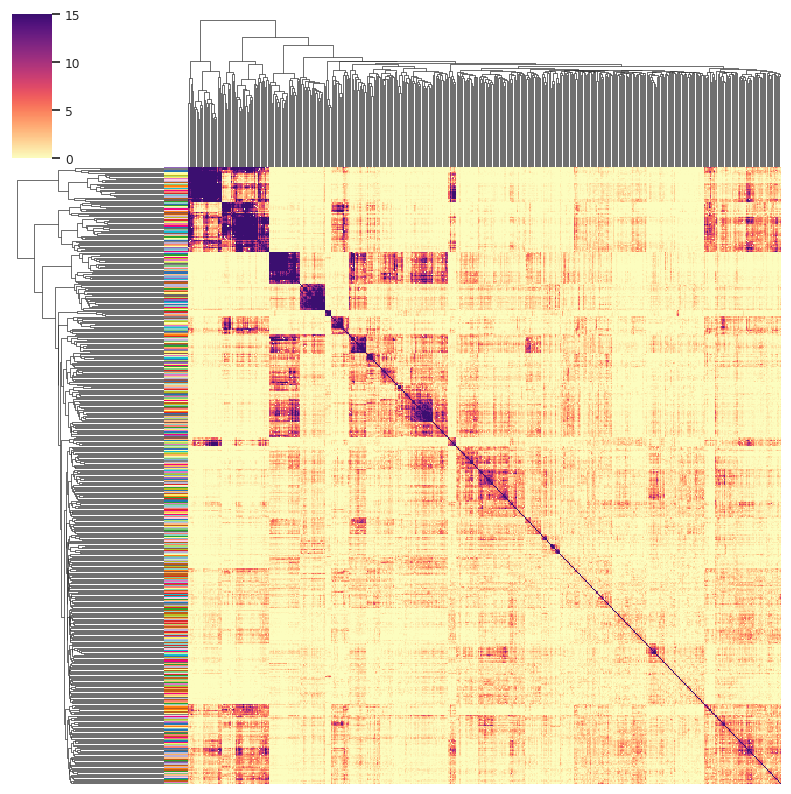

In [12]:
# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

row_linkage = hierarchy.linkage(distance.pdist(Jdata), method='average')
col_linkage = hierarchy.linkage(distance.pdist(Jdata.T), method='average')

cm = sns.clustermap(
    Jdata,
    row_linkage=row_linkage, 
    col_linkage=col_linkage,
    method="average",
    cmap = CustomMagma,
    vmin = 0,
    vmax = 15,
    xticklabels = False,
    yticklabels = False,
    row_colors = pd.Series(ColorDict).map(ColorValues).to_numpy(),
    figsize = (8,8),
    # tree_kws = {'colors':[(1,0,0,1)]*len(Jdata)},
    rasterized = False)

In [ ]:
# Find dendogram clusters 
clusters = pd.DataFrame(data=scipy.cluster.hierarchy.fcluster(row_linkage, t=10 , criterion='maxclust'), 
                        index=list(ModuleDict.keys()), 
                        columns= ["Cluster"])

# clusters.to_csv(clustfolder +"JaccardIndex_Clusters_30knn100genes.csv")

ColorCluster = dict(map(lambda i,j : (i,j) , set(clusters['Cluster']), sns.color_palette("Paired", len(set(clusters['Cluster'])))))
clusters['Cluster'] = [*map(ColorCluster.get, list(clusters['Cluster']))]
ColorCluster = dict(clusters['Cluster'])

cm = sns.clustermap(
    Jdata,
    row_linkage=row_linkage, 
    col_linkage=col_linkage,
    method="average",
    cmap = CustomMagma,
    vmin = 0,
    vmax = 50,
    xticklabels = False,
    yticklabels = False,
    row_colors = [pd.Series(ColorCluster).to_numpy(),pd.Series(ColorDict).map(ColorValues).to_numpy()],
    figsize = (8,8),
    # tree_kws = {'linewidths':1,'colors':list(ColorCluster.values())},
    rasterized = False)
fig = plt.gcf()

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("Patient modules")

from matplotlib.patches import Patch

handles = [Patch(facecolor = ColorValues[name]) for name in ColorValues]
plt.legend(handles, ColorValues, title='Patient',
           bbox_to_anchor=(1, 0.5), loc = 'center left', facecolor= 'white')


cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1.1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

# cm.dendrogram_row.reordered_ind
cm.savefig("Hotspot/MSS/Clustermap_30knn200genes.pdf")
plt.savefig("Hotspot/MSS/Clustermap_30knn200genes.png",bbox_inches='tight')

# Jaccard Index Filter


In [ ]:
J_ord = J_df.reindex(J_df.index[cm.dendrogram_col.reordered_ind])
J_ord = J_ord.reindex(columns = J_ord.index[cm.dendrogram_col.reordered_ind])
J_ord = J_ord.replace(100,0)
J_ord
J_ord.to_csv("Hotspot/MSS/JaccardIndex_Ordered_30knn200genes.csv")
J_ord.shape
J_ord.max(axis=1)
max(J_ord.max(axis=1))
min(J_ord.max(axis=1))
import statistics

sns.histplot(data = J_ord.max(axis=1), bins=20)
len(set(J_ord.index)-set(J_ord[J_ord.max(axis=1) <= 10].index))

J_filtered = J_df.loc[set(J_ord.index)-set(J_ord[J_ord.max(axis=1) <= 10].index),set(J_ord.index)-set(J_ord[J_ord.max(axis=1) <= 10].index)]
J_filtered

In [ ]:
# J_filtered.to_csv(clustfolder +"JaccardIndex_MatrixFiltered_PelkaSabine_30knn100genes.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('magma_r', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0, 0.8, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

row_linkage = hierarchy.linkage(distance.pdist(J_filtered), method='average')
col_linkage = hierarchy.linkage(distance.pdist(J_filtered.T), method='average')

cm = sns.clustermap(
    J_filtered,
    row_linkage=row_linkage, 
    col_linkage=col_linkage,
    method="average",
    cmap = CustomMagma,
    vmin = 0,
    vmax = 15,
    xticklabels = False,
    yticklabels = False,
    row_colors = pd.Series(ColorDict).map(ColorValues).to_numpy(),
    figsize = (8,8),
    # tree_kws = {'colors':[(1,0,0,1)]*len(Jdata)},
    rasterized = False)

# Find dendogram clusters 
clusters = pd.DataFrame(data=scipy.cluster.hierarchy.fcluster(row_linkage, t=10 , criterion='maxclust'), 
                        index=list(J_filtered.index), 
                        columns= ["Cluster"])

clusters.to_csv("Hotspot/MSS/JaccardIndex_ClustersFiltered_Pelka_30knn200genes.csv")

ColorCluster = dict(map(lambda i,j : (i,j) , set(clusters['Cluster']), sns.color_palette("Paired", len(set(clusters['Cluster'])))))
clusters['Cluster'] = [*map(ColorCluster.get, list(clusters['Cluster']))]
ColorCluster = dict(clusters['Cluster'])

cm = sns.clustermap(
    J_filtered,
    row_linkage=row_linkage, 
    col_linkage=col_linkage,
    method="average",
    cmap = CustomMagma,
    vmin = 0,
    vmax = 25,
    xticklabels = False,
    yticklabels = False,
    row_colors = pd.Series(ColorCluster).to_numpy(),
    figsize = (8,8),
    # tree_kws = {'linewidths':1,'colors':list(ColorCluster.values())},
    rasterized = False)
fig = plt.gcf()

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("Patient modules")

from matplotlib.patches import Patch

handles = [Patch(facecolor = ColorValues[name]) for name in ColorValues]
plt.legend(handles, ColorValues, title='Patient',
           bbox_to_anchor=(1, 0.5), loc = 'center left', facecolor= 'white')


cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1.2, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

# cm.dendrogram_row.reordered_ind
cm.savefig("Hotspot/MSS/Clustermap_Filtered_Pelka_30knn200genes.pdf")
plt.savefig("Hotspot/MSS/Clustermap_Filtered_Pelka_30knn200genes.png",bbox_inches='tight')

# Comparison to other modules

In [ ]:
import json
# Build signature dictionary 
Sigs_xlsx = pd.read_excel('/Volumes/biostats/emiddendorp/Signatures/SignaturesMSS.xlsx')  
column_names_Sigs = list(Sigs_xlsx.columns.values)
iCMS = pd.read_excel('/Volumes/biostats/emiddendorp/Datasets/Pelka/Metadata/Signatures/iCMS.xlsx', sheet_name = "Supplementary Table 14")  
Pol1 = pd.read_excel("/Volumes/biostats/emiddendorp/Signatures/Signature POLI up .xlsx")  
column_names_Pol1 = list(Pol1.columns.values)
Signatures = {'EpiHR':[x for x in Sigs_xlsx[column_names_Sigs[0]] if str(x) != 'nan'],
              'CorHRC':[x for x in Sigs_xlsx[column_names_Sigs[1]] if str(x) != 'nan'],
              'Fetal':[x for x in Sigs_xlsx[column_names_Sigs[2]] if str(x) != 'nan'],
              'RevSC':[x for x in Sigs_xlsx[column_names_Sigs[3]] if str(x) != 'nan'],
              'YAP22':[x for x in Sigs_xlsx[column_names_Sigs[4]] if str(x) != 'nan'],
              'hsREV':[x for x in Sigs_xlsx[column_names_Sigs[5]] if str(x) != 'nan'],
              'LGR5_Munoz':["AK7","PLCE1","NOTCH1","FAM171A1","OLFM4","CEP192","KANK1","MCC",  "KLHL24","TTC21B","ENGASE",
                            "TIAM1","EHF",  "ZC3HAV1L","CNN3", "AQP1", "TNS4", "SMARCD3","HMBOX1","TNFSF10", "CC2D2A","POGK",
                            "PELI2","EPHA4","RDH16","PTPRM","TBC1D19", "SORBS2","DTL",  "NAV1","GPLD1","LPAR6","CTTNBP2", 
                            "CENPF","ZNRF3","GRB7","ACVR2B","YAP1", "TUBB2B","SEMA7A","VDR",  "RHOBTB3","NRG4", "PRKACB","MYC",
                            "SFRP5","BRCA2","ESPL1","MECOM","BCL7A","ACSM3","SMOC2","TNS3", "CGNL1","HUNK", "RCCD1","PPM1F",
                            "SLCO3A1", "PDE3B","FBXO21", "KIF12","CLCA2","DAPK2","ZBTB12","ATG16L2", "TEX9","MSI1", "SMPX", 
                            "LRIG1","SESN3","POLI", "DCTD","ZMYM1","MLH3", "FSTL1","CITED4","GEMIN8","APCDD1", "SRL",  "PTPRO",
                            "MPZL3","GAS6", "CCDC18","CSAD","ZFHX3","AQP4", "MLXIP","IGFBP4","MDN1", "POLE","SESTD1","ASCL2",
                            "SORD", "TGIF2","LECT2","SLC27A2","TNFRSF19","NRTN","TMEM9","PRKD3","ELL3","ERI2","PCDH8","SLC19A2",
                            "CYP2E1","NOTCH2","BCKDHB","CLU","TNFAIP8L1","TRIM32","DCT",  "KRT23","PLXNB1","IL17RD", "HEMGN",
                            "VAV3","PLEKHB1", "FHDC1","EMP2", "NRN1","PPAT", "MFGE8","IRF2BP2", "KLHL8","ASPM", "SEMA3B",
                            "SLC39A10","WWTR1","MPP3", "PLA2G4A", "TMEM132A","PHC1","RPRD1A","CDCA7L","TIFA", "PDS5B","BHLHB9",
                            "CDO1","GKAP1","LAMB3","EFNA4","GABBR1","ISYNA1","FADS1","PTPRS","NFIA", "TBC1D4","TEAD2","FMNL2",
                            "ALMS1","UTRN", "MEX3A","GINS1","FZD2", "LIMK2","BCL2","WWP1", "CLCA1","SHISA2","PDGFA","SLC16A13",
                            "NAP1L1", "CIT",  "APP",  "GRAMD1A", "IRS1", "CACHD1","IMPDH2", "ARL4C","AGR3", "PAICS","ATR",
                            "DYNC2H1", "TRIM24", "LGR5", "AXIN2","PSRC1","ETV6", "CLIC6","CSNK1E", "DDO",  "GLRX", "PRPF40B", 
                            "TLR2", "GREB1","PDE8B","EVL",  "PHLPP1","IFT122","CD44", "TBC1D9","S100PBP","PCK2", "CDK6", "UNG",
                            "TXNDC16", "SLC12A2", "NFIC","KCNE3","PNPLA7","FZD7", "DMPK", "TRIM37","SP5", "CDC42EP1","LIPT2",
                            "CPN1", "PLS3", "IMMP2L","NAPEPLD","ATP11A","PRSS23","NIN",  "HIRIP3","DACH1","MARVELD1","XRCC5",
                            "WDR90","MAN2A2","TSPAN5","RASSF5","HAUS4","TTC23","QSOX2","ESRRG","PPP1R9A", "ELMO1","FRAS1",
                            "PICALM","PHLDB2","ALDH7A1", "SDC4", "CD320","CKAP2","KCNQ1","ZBTB25","SOX4", "KLHL23",
                            "PHOSPHO2-KLHL23" "MPZL1","RASA3","ADRA2A","VNN1", "ATM",  "SOX9", "ACOT2","IFFO2","ILF3", "ZFP90",
                            "MYO1B","TFPI", "TTPA","MCM8", "NR2E3","FGD1", "STK39","SOAT1","LYSMD2", "DTX4", "KIF20A","AFAP1L1",
                            "CLCA4","RASL11B", "ZRANB3","SLC23A3", "RNF32","PBX1", "AFAP1","CDCA7","PHF20","RNF43","MAGED1",
                            "MIF",  "PRELP","ESAM", "SNX10","LCP1", "WDR35","TMEM209", "RHBDF1","TRIM44","BLNK","PRPS2","RGMB",
                            "EPHB3","RASSF4","FARP1","CIITA","SCN2B","SPAG5","SLC44A2", "DDB2", "SGK1", "FGFR4","NOD1", 
                            "HDAC11","RGS12","PALB2","ANGPT2","SMO", "SORCS2","POLD1","FAM189B", "TGIF1","SLC14A1"],
              'Proliferation':["ERCC6L","STOX1", "WDHD1", "ROBO2", "NPHP1", "C18orf54"  "CNTLN", "ESCO2", "CKAP2L","ANLN", 
                               "HELLS", "BUB1",  "PBK",   "E2F7",  "NEK2",  "KIF14", "SLFN13","TTC26", "DEPDC1","DOCK10",
                               "EXO1",  "RETNLB","CDT1",  "NEIL3", "CHEK1", "NRM",   "MCM10", "RAD54B","MCM2",  "SYNE1",
                               "CELSR1","CCNB1", "ZNF367","RGS10", "ARL13B","CCNA2", "KIF18B","MSH6",  "RBL1",  "GINS2",
                               "PRC1",  "NUP210","FRZB",  "PLK4",  "POU2AF1"   "TOP2A", "SPC25", "PRIM1", "CENPH", "CACNA2D2", 
                               "CD200", "ELAVL2","SORBS1","HS6ST2","CDR2L", "RAD51AP1"  "SLCO5A1"   "UHRF1", "MYCN",  "FEN1", 
                               "TYMS",  "STXBP1","MAD2L1","BUB1B", "CDC7",  "FUT1",  "CCDC15","IQGAP3","RRM1",  "TACSTD2",  
                               "DSCAML1"   "KIF23", "AS3MT", "NCAPG", "DSCC1", "PKIA",  "PAK6",  "SAMD5", "VANGL2","KIF11",
                               "RFC3",  "TCF19", "PMP22", "FIGNL1","BRCA1", "CENPK", "PMCH",  "TFPI",  "WDR76", "CD44", 
                               "RRM2",  "SESTD1","DHFR",  "NUSAP1","SETD7", "CHRNA5","RAB11FIP3" "USP13", "MDFIC", "E2F8", 
                               "FANCI", "TROAP", "GINS1", "PTGDR", "ERG",   "NAP1L1","SNX10", "CHRNA3","ULK2",  "OIP5", 
                               "CENPM", "CENPI", "BIRC5", "UBE2T", "GTSE1", "CBFA2T3","KATNAL1"   "DUSP10","LRP8",  "IL17RB",   
                               "AURKB", "CDC6",  "CDK6",  "CLCA2", "MCM6",  "FAM83D","SLC24A3"   "ECT2",  "FANCA", "MCM7", 
                               "CTNNAL1"   "CYP1B1","PDGFC", "TK1",   "KNTC1", "ARNTL2","RNASEH2A"  "FANCD2","CEP78", "STIL", 
                               "PSAT1", "SEMA4D","CENPN", "MTBP",  "RAD51", "SLC4A7","CHAF1B","PRSS21","AQP3",  "EIF2AK4",  
                               "NCAPG2","DCLRE1B","ATAD5", "DENND5A","CDC25A","CDC20", "SMC2",  "VRK1"],
              'Smillie_Best4':[x for x in Sigs_xlsx[column_names_Sigs[6]] if str(x) != 'nan'],
              'Smillie_Cycling TA':[x for x in Sigs_xlsx[column_names_Sigs[7]] if str(x) != 'nan'],
              'Smillie_Immature_Enterocytes':[x for x in Sigs_xlsx[column_names_Sigs[8]] if str(x) != 'nan'],
              'Smillie_Enterocyte_Progenitors':[x for x in Sigs_xlsx[column_names_Sigs[9]] if str(x) != 'nan'],
              'Smillie_Enterocytes':[x for x in Sigs_xlsx[column_names_Sigs[10]] if str(x) != 'nan'],
              'Smillie_Enteroendocrine':[x for x in Sigs_xlsx[column_names_Sigs[11]] if str(x) != 'nan'],
              'Smillie_Goblet':[x for x in Sigs_xlsx[column_names_Sigs[12]] if str(x) != 'nan'],
              'Smillie_Immature_Enterocytes_1':[x for x in Sigs_xlsx[column_names_Sigs[13]] if str(x) != 'nan'],
              'Smillie_Immature_Enterocytes_2':[x for x in Sigs_xlsx[column_names_Sigs[14]] if str(x) != 'nan'],
              'Smillie_Immature_Goblet':[x for x in Sigs_xlsx[column_names_Sigs[15]] if str(x) != 'nan'],
              'Smillie_M_cells':[x for x in Sigs_xlsx[column_names_Sigs[16]] if str(x) != 'nan'],
              'Smillie_Secretory_TA':[x for x in Sigs_xlsx[column_names_Sigs[17]] if str(x) != 'nan'],
              'Smillie_Stem':[x for x in Sigs_xlsx[column_names_Sigs[18]] if str(x) != 'nan'],
              'Smillie_TA_1':[x for x in Sigs_xlsx[column_names_Sigs[19]] if str(x) != 'nan'],
              'Smillie_TA_2':[x for x in Sigs_xlsx[column_names_Sigs[20]] if str(x) != 'nan'],
              'Smillie_Tuft':[x for x in Sigs_xlsx[column_names_Sigs[21]] if str(x) != 'nan'],
              'iCMS2':[x for x in iCMS["iCMS2_Up"] if str(x) != 'nan'],
              'iCMS3':[x for x in iCMS["iCMS3_Up"] if str(x) != 'nan'],
              'POL1':[x for x in Pol1[column_names_Pol1[0]] if str(x) != 'nan'],
              'PDAC':["KRT6A","S100A2","KRT13","KRT17","LY6D","KRT7","KRT5","FAM83A","CD109","GAPDH","CSTA","PTPN13","MTSS1","SPRR1B","SLC2A1","CAV1","EMP1","SEMA3C","DHRS9","CAST","FLNA","SLITRK6","COL7A1","AQP3","MT2A","AHNAK2","KRT19","PKP1","YBX3", "GJB5"]}
Signatures.keys()

# HALLMARK dictionary

with open('/Volumes/biostats/emiddendorp/Signatures/HALLMARKS_20230509.json') as f:
    data = f.read()
js = json.loads(data)
keys = list(js.keys())
keys = [x.replace('HALLMARK_', '').title() for x in keys]
values = [js[list(js.keys())[i]]['geneSymbols'] for i in range(0, len(keys))]
HALLMARKS =  dict(map(lambda i,j : (i,j) , keys,values))

# Build signature dictionary 
Tirosh_xlsx = pd.read_excel('/Volumes/biostats/emiddendorp/Datasets/Pelka/Metadata/Signatures/Tirosh_MPs.xlsx')  
column_names_Tirosh = list(Tirosh_xlsx.columns.values)
len(column_names_Tirosh)
Tirosh = {
    column_names_Tirosh[0]:[x for x in Tirosh_xlsx[column_names_Tirosh[0]] if str(x) != 'nan'],
    column_names_Tirosh[1]:[x for x in Tirosh_xlsx[column_names_Tirosh[1]] if str(x) != 'nan'],
    column_names_Tirosh[2]:[x for x in Tirosh_xlsx[column_names_Tirosh[2]] if str(x) != 'nan'],
    column_names_Tirosh[3]:[x for x in Tirosh_xlsx[column_names_Tirosh[3]] if str(x) != 'nan'],
    column_names_Tirosh[4]:[x for x in Tirosh_xlsx[column_names_Tirosh[4]] if str(x) != 'nan'],
    column_names_Tirosh[5]:[x for x in Tirosh_xlsx[column_names_Tirosh[5]] if str(x) != 'nan'],
    column_names_Tirosh[6]:[x for x in Tirosh_xlsx[column_names_Tirosh[6]] if str(x) != 'nan'],
    column_names_Tirosh[7]:[x for x in Tirosh_xlsx[column_names_Tirosh[7]] if str(x) != 'nan'],
    column_names_Tirosh[8]:[x for x in Tirosh_xlsx[column_names_Tirosh[8]] if str(x) != 'nan'],
    column_names_Tirosh[9]:[x for x in Tirosh_xlsx[column_names_Tirosh[9]] if str(x) != 'nan'],
    column_names_Tirosh[10]:[x for x in Tirosh_xlsx[column_names_Tirosh[10]] if str(x) != 'nan'],
    column_names_Tirosh[11]:[x for x in Tirosh_xlsx[column_names_Tirosh[11]] if str(x) != 'nan'],
    column_names_Tirosh[12]:[x for x in Tirosh_xlsx[column_names_Tirosh[12]] if str(x) != 'nan'],
    column_names_Tirosh[13]:[x for x in Tirosh_xlsx[column_names_Tirosh[13]] if str(x) != 'nan'],
    column_names_Tirosh[14]:[x for x in Tirosh_xlsx[column_names_Tirosh[14]] if str(x) != 'nan'],
    column_names_Tirosh[15]:[x for x in Tirosh_xlsx[column_names_Tirosh[15]] if str(x) != 'nan'],
    column_names_Tirosh[16]:[x for x in Tirosh_xlsx[column_names_Tirosh[16]] if str(x) != 'nan'],
    column_names_Tirosh[17]:[x for x in Tirosh_xlsx[column_names_Tirosh[17]] if str(x) != 'nan'],
    column_names_Tirosh[18]:[x for x in Tirosh_xlsx[column_names_Tirosh[18]] if str(x) != 'nan'],
    column_names_Tirosh[19]:[x for x in Tirosh_xlsx[column_names_Tirosh[19]] if str(x) != 'nan'],
    column_names_Tirosh[20]:[x for x in Tirosh_xlsx[column_names_Tirosh[20]] if str(x) != 'nan'],
    column_names_Tirosh[21]:[x for x in Tirosh_xlsx[column_names_Tirosh[21]] if str(x) != 'nan'],
    column_names_Tirosh[22]:[x for x in Tirosh_xlsx[column_names_Tirosh[22]] if str(x) != 'nan'],
    column_names_Tirosh[23]:[x for x in Tirosh_xlsx[column_names_Tirosh[23]] if str(x) != 'nan'],
    column_names_Tirosh[24]:[x for x in Tirosh_xlsx[column_names_Tirosh[24]] if str(x) != 'nan'],
    column_names_Tirosh[25]:[x for x in Tirosh_xlsx[column_names_Tirosh[25]] if str(x) != 'nan'],
    column_names_Tirosh[26]:[x for x in Tirosh_xlsx[column_names_Tirosh[26]] if str(x) != 'nan'],
    column_names_Tirosh[27]:[x for x in Tirosh_xlsx[column_names_Tirosh[27]] if str(x) != 'nan'],
    column_names_Tirosh[28]:[x for x in Tirosh_xlsx[column_names_Tirosh[28]] if str(x) != 'nan'],
    column_names_Tirosh[29]:[x for x in Tirosh_xlsx[column_names_Tirosh[29]] if str(x) != 'nan'],
    column_names_Tirosh[30]:[x for x in Tirosh_xlsx[column_names_Tirosh[30]] if str(x) != 'nan'],
    column_names_Tirosh[31]:[x for x in Tirosh_xlsx[column_names_Tirosh[31]] if str(x) != 'nan'],
    column_names_Tirosh[32]:[x for x in Tirosh_xlsx[column_names_Tirosh[32]] if str(x) != 'nan'],
    column_names_Tirosh[33]:[x for x in Tirosh_xlsx[column_names_Tirosh[33]] if str(x) != 'nan'],
    column_names_Tirosh[34]:[x for x in Tirosh_xlsx[column_names_Tirosh[34]] if str(x) != 'nan'],
    column_names_Tirosh[35]:[x for x in Tirosh_xlsx[column_names_Tirosh[35]] if str(x) != 'nan'],
    column_names_Tirosh[36]:[x for x in Tirosh_xlsx[column_names_Tirosh[36]] if str(x) != 'nan'],
    column_names_Tirosh[37]:[x for x in Tirosh_xlsx[column_names_Tirosh[37]] if str(x) != 'nan'],
    column_names_Tirosh[38]:[x for x in Tirosh_xlsx[column_names_Tirosh[38]] if str(x) != 'nan'],
    column_names_Tirosh[39]:[x for x in Tirosh_xlsx[column_names_Tirosh[39]] if str(x) != 'nan'],
    column_names_Tirosh[40]:[x for x in Tirosh_xlsx[column_names_Tirosh[40]] if str(x) != 'nan']}
Tirosh.keys()

In [ ]:
# Build MetaModule Dictionary 
clustnumb = 12
clustfolder = "/Volumes/biostats/emiddendorp/Datasets/Pelka/JaccardIndex2/Clusters/"

Metamodules12 = dict()

for i in range(1,clustnumb+1):
    metamodule_df = pd.read_csv(clustfolder+"Module"+str(i)+".csv").set_index('Unnamed: 0')
    # metamodule_df = pd.read_csv(clustfolder+"Module"+str(i)+"_filtered.csv").set_index('Unnamed: 0')
    Metamodules12["Metamodule "+str(i)]= list(metamodule_df['Gene'].values)

Metamodules12.keys()

In [ ]:
# Build MetaModule OLD Dictionary 
clustnumb = 20
clustfolder = "/Volumes/biostats/emiddendorp/Datasets/Pelka/JaccardIndex/20Clusters/"

MetamodulesOLD = dict()

for i in range(1,clustnumb+1):
    metamodule_df = pd.read_csv(clustfolder+"Module"+str(i)+"_filtered.csv").set_index('Unnamed: 0')
    MetamodulesOLD["Metamodule "+str(i)]= list(metamodule_df['Gene'].values)

MetamodulesOLD.keys()

In [ ]:
# Build MetaModule NEW Dictionary 
clustfolder = "/Volumes/biostats/emiddendorp/Datasets/Pelka2/Modules/MSS/"

Metamodules = dict()

for i in range(1,11):
    metamodule_df = pd.read_csv(clustfolder+"Module"+str(i)+".csv").set_index('Unnamed: 0')
    Metamodules["Metamodule "+str(i)]= list(metamodule_df['Gene'].values)

Metamodules.keys()

In [ ]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
JSigs = np.zeros((len(Metamodules),len(Signatures)))
JSigs.shape
# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in Metamodules.keys():
    J = []
    A = set(Metamodules.get(x))
    for x in Signatures.keys():
        B = set(Signatures.get(x))
        J.append(len(A.intersection(B)) / len(A.union(B))*100)
    JSigs[i,:] = J
    i = i+1
# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=JSigs, index=list(Metamodules.keys()), columns=list(Signatures.keys()))
J_df
# J_df.to_csv(clustfolder +"JaccardIndex_Matrix_Signatures.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('viridis', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0.1, 1, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

cm = sns.clustermap(
    J_df,
    cmap = cm.get_cmap('viridis', 512),
    row_cluster=False,
    col_cluster=False,
    # vmin = 0,
    # vmax = 5,
    figsize = (15,10),
    rasterized = False)

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

# cm.savefig(clustfolder +'Clustermap_Signatures_Unfiltered.pdf')
# plt.savefig(clustfolder +'Clustermap_signatures_Unfiltered.png',bbox_inches='tight')

In [ ]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
JSigs = np.zeros((len(Metamodules),len(HALLMARKS)))
JSigs.shape
# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in Metamodules.keys():
    J = []
    A = set(Metamodules.get(x))
    for x in HALLMARKS.keys():
        B = set(HALLMARKS.get(x))
        J.append(len(A.intersection(B)) / len(A.union(B))*100)
    JSigs[i,:] = J
    i = i+1
# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=JSigs, index=list(Metamodules.keys()), columns=list(HALLMARKS.keys()))
J_df
# J_df.to_csv(clustfolder +"JaccardIndex_Matrix_HALLMARKS.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('viridis', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0.1, 1, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

cm = sns.clustermap(
    J_df,
    cmap = cm.get_cmap('viridis', 512),
    row_cluster=False,
    col_cluster=False,
    vmin = 0,
    vmax = 5,
    figsize = (15,10),
    rasterized = False)

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

cm.savefig(clustfolder +'Clustermap_HALLMARKS_unfiltered.pdf')
plt.savefig(clustfolder +'Clustermap_HALLMARKS_unfiltered.png',bbox_inches='tight')

In [ ]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
JSigs = np.zeros((len(Metamodules),len(Tirosh)))
JSigs.shape
# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in Metamodules.keys():
    J = []
    A = set(Metamodules.get(x))
    for x in Tirosh.keys():
        B = set(Tirosh.get(x))
        J.append(len(A.intersection(B)) / len(A.union(B))*100)
    JSigs[i,:] = J
    i = i+1
# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=JSigs, index=list(Metamodules.keys()), columns=list(Tirosh.keys()))
J_df
# J_df.to_csv(clustfolder +"JaccardIndex_Matrix_HALLMARKS.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('viridis', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0.1, 1, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

cm = sns.clustermap(
    J_df,
    cmap = cm.get_cmap('viridis', 512),
    row_cluster=False,
    col_cluster=False,
    vmin = 0,
    vmax = 5,
    figsize = (15,10),
    rasterized = False)

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

cm.savefig(clustfolder +'Clustermap_Tirosh_Unfiltered.pdf')
plt.savefig(clustfolder +'Clustermap_Tirosh_Unfiltered.png',bbox_inches='tight')

In [ ]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
JSigs = np.zeros((len(Metamodules),len(MetamodulesOLD)))
JSigs.shape
# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in Metamodules.keys():
    J = []
    A = set(Metamodules.get(x))
    for x in MetamodulesOLD.keys():
        B = set(MetamodulesOLD.get(x))
        J.append(len(A.intersection(B)) / len(A.union(B))*100)
    JSigs[i,:] = J
    i = i+1
# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=JSigs, index=list(Metamodules.keys()), columns=list(MetamodulesOLD.keys()))
J_df
# J_df.to_csv(clustfolder +"JaccardIndex_Matrix_HALLMARKS.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('viridis', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0.1, 1, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

cm = sns.clustermap(
    J_df,
    cmap = cm.get_cmap('viridis', 512),
    row_cluster=False,
    col_cluster=False,
    # vmin = 0,
    # vmax = 5,
    figsize = (15,10),
    rasterized = False)

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

cm.savefig(clustfolder +'Clustermap_MetamodulesOld_Unfiltered.pdf')
plt.savefig(clustfolder +'Clustermap_MetamodulesOld_Unfiltered.png',bbox_inches='tight')

In [ ]:
#################################
##        JACCARD INDEX        ##
#################################
## J(A,B) = (A n B) / (A u B)  ##
#################################

# Allocate data matrix
JSigs = np.zeros((len(Metamodules),len(Metamodules12)))
JSigs.shape
# Calculate Jaccard index for all modules vs. all modules 
i = 0
for x in Metamodules.keys():
    J = []
    A = set(Metamodules.get(x))
    for x in Metamodules12.keys():
        B = set(Metamodules12.get(x))
        J.append(len(A.intersection(B)) / len(A.union(B))*100)
    JSigs[i,:] = J
    i = i+1
# Export data as data frame to save in csv 
J_df = pd.DataFrame(data=JSigs, index=list(Metamodules.keys()), columns=list(Metamodules12.keys()))
J_df
# J_df.to_csv(clustfolder +"JaccardIndex_Matrix_HALLMARKS.csv")

# Modified color scale 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
MagmaFull = cm.get_cmap('viridis', 512)
CustomMagma =ListedColormap(MagmaFull(np.linspace(0.1, 1, 323)))

# Heatmap
sns.set(font_scale = 0.8)

from scipy.spatial import distance
from scipy.cluster import hierarchy

cm = sns.clustermap(
    J_df,
    cmap = cm.get_cmap('viridis', 512),
    row_cluster=False,
    col_cluster=False,
    # vmin = 0,
    # vmax = 5,
    figsize = (15,10),
    rasterized = False)

plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
cm.ax_cbar.set_position((1, .2, .03, .4))
cm.ax_cbar.set_title('Jaccard Index',fontsize=10, rotation = 270)

# cm.savefig(clustfolder +'Clustermap_MetamodulesOld_Unfiltered.pdf')
# plt.savefig(clustfolder +'Clustermap_MetamodulesOld_Unfiltered.png',bbox_inches='tight')